# Movie Recommendation System

The goal of this assignment is give you practice working with Singular Value Decomposition. Your task is implement a matrix factorization method-such as singular value decomposition (SVD).


## Recommender System using SVD

Matrix factorization can be used to discover features underlying the interactions between two different kinds of entities. And one obvious application is to predict ratings in collaborative filtering—in other words, to recommend items to users.

One advantage of employing matrix factorization for recommender systems is the fact that it can incorporate implicit feedback—information that’s not directly given but can be derived by analyzing user behavior—such as items frequently bought or viewed.

Using this capability we can estimate if a user is going to like a movie that they never saw. And if that estimated rating is high, we can recommend that movie to the user, so as to provide a more personalized experience.

For example, two users might give high ratings to a certain movie if they both like the actors/actresses of the movie, or if the movie is a thriller movie, which is a genre preferred by both users.

Hence, if we can discover these kinds of latent features (like genre or actors and directors), we should be able to predict a rating with respect to a certain user and a certain item, because the features associated with the user should match with the features associated with the item.


The data input for a recommender system can be thought of as a large matrix, with the rows indicating an entry for a customer, and the columns indicating an entry for a particular item. Let’s call this matrix $R$. Then entry $R_{i,j}$ will contain the score that customer $i$ has given to product $j$. For example if it’s a review this could be a number from 1–5, or it might just be 0–1 indicating if a user has bought an item or not. This matrix contains a lot of missing information, it’s unlikely a customer has bought every item on Amazon! Recommender systems aim to fill in this missing information, by predicting the customer score of items where the score is missing. Then recommender systems will recommend items to the customer that have the highest score. A typical example of the matrix $R$ with entries that are review values from 1–5 is given in the picture below.

<img src="images/ex_im_1.png" alt="Utility Matrix" style="width: 80%"/>

#### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.linalg import sqrtm

#### Dataset

The dataset we’ll be working with is a very famous movies dataset: the ml-1m, or the [MovieLens dataset 100 k](https://grouplens.org/datasets/movielens/100k).

##### 1. Data Preprocessing
We will begin by loading the dataset file present in the `.csv` file into pandas dataframes and visualizing the entries.

In [2]:
data = pd.read_csv('movielens100k.csv')
data['userId'] = data['userId'].astype('string')
data['movieId'] = data['movieId'].astype('string')

users = list(set(data['userId'])) #list of all users
movies = list(set(data['movieId'])) #list of all movies

print("Number of users", len(users))
print("Number of movies", len(movies))

data.head()

Number of users 718
Number of movies 8915


userId movieId  rating  timestamp
0      1       1     5.0  847117005
1      1       2     3.0  847642142
2      1      10     3.0  847641896
3      1      32     4.0  847642008
4      1      34     4.0  847641956

##### 2. Split the data into a train and test set

In [3]:
test = pd.DataFrame(columns=data.columns)
train = pd.DataFrame(columns=data.columns)
test_ratio = 0.2 #adjust it as per wish

for u in users[:]:
    temp = data[data['userId'] == u]
    n = len(temp)
    test_size = int(test_ratio*n)

    temp = temp.sort_values('timestamp').reset_index()
    temp.drop('index', axis=1, inplace=True)

    dummy_test = temp.iloc[n-1-test_size :]
    dummy_train = temp.iloc[: n-2-test_size]

    test = pd.concat([test, dummy_test])
    train = pd.concat([train, dummy_train])

##### 3. Create the utility matrix

The input data will now be converted to the utility matrix $(n\times m)$ where the rows of the matrix are users $n$ and the columns are the ratings for the $m$-th movie.

In [4]:
# Create_utility_matrix
def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
    """
        :param data:       Array-like, 2D, nx3
        :param formatizer: pass the formatizer
        :return:           the utility matrix. 2D, n x m, n=users, m=items
    """

    itemField = formatizer['item']
    userField = formatizer['user']
    valueField = formatizer['value']
    userList = data.iloc[:,userField].tolist()
    itemList = data.iloc[:,itemField].tolist()
    valueList = data.iloc[:,valueField].tolist()
    users = list(set(data.iloc[:,userField]))
    items = list(set(data.iloc[:,itemField]))
    users_index = {users[i]: i for i in range(len(users))}
    pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    for i in range(0,len(data)):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]
        pd_dict[item][users_index[user]] = value
    X = pd.DataFrame(pd_dict)
    X.index = users
    
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    # users_index gives us a mapping of user_id to index of user
    # items_index provides the same for items
    return X, users_index, items_index

utilMat, users_index, items_index = create_utility_matrix(train)

#### Metric computation

The function rmse computes the root mean square error (RMSE) for the true and the predicted movie ratings.

In [5]:
def rmse(true, pred):
    # this will be used towards the end
    x = true - pred
    return sum([xi*xi for xi in x])/len(x)

#### Code for computing SVD for the utility matrix [Write your code here]

In [6]:
# reflixing utility matrix as without it, SVD does not converge

actual_utility_matrix=np.array(utilMat)
mask = np.isnan(actual_utility_matrix)
masked_arr = np.ma.masked_array(actual_utility_matrix, mask)
item_means = np.mean(masked_arr, axis=0)
actual_utility_matrix = masked_arr.filled(item_means)
x = np.tile(item_means, (actual_utility_matrix.shape[0], 1))
actual_utility_matrix = actual_utility_matrix - x

In [7]:
def svd(k):
    U, s, V = np.linalg.svd(actual_utility_matrix, full_matrices=False)
    
    s = np.diag(s)
    s = s[0:k, 0:k]
    U = U[:, 0:k]
    V = V[0:k, :]
        
    Usk = np.dot(U, sqrtm(s))
    skV = np.dot(sqrtm(s), V)
    UsV = np.dot(Usk, skV)+ x

    return UsV


#### Code for the test set [Write your code here]

Write the code that computes the RMSE for the predicted ratings for the test data present in the `test` matrix.

In [8]:
def calc_mse(k):
    svd_out = svd(k)
    pred = []  # to store the predicted ratings
    for _, row in test.iterrows():
        user = row['userId']
        item = row['movieId']
        u_index = users_index[user]
        if item in items_index:
            i_index = items_index[item]
            pred_rating = svd_out[u_index, i_index]
        else:
            pred_rating = np.mean(svd_out[u_index, :])
        pred.append(pred_rating)
    return rmse(test['rating'], pred)

In [9]:
calc_mse(9) # as a minima is observed here, as in graph drawn below

0.9624551442352153

In [10]:
# to test the performance over a different number of features
no_of_features = range(0, 105)
plotting = []

for f in no_of_features:
    try:
        errr=calc_mse(f)
        print(f, errr)
        plotting += [[f, errr]]
    except:
        continue

1 0.9699442127770986
2 0.9700271491728044
3 0.9675593319379073
4 0.9668167209140435
5 0.9651167059017375
6 0.9634459056195791
7 0.9631666230809471
8 0.9630898543487932
9 0.9624551442352153
10 0.9632320309708643
11 0.9635170902573349
12 0.9645970994047945
13 0.9649666087856603
14 0.9632251443983256
15 0.9626140805934432
16 0.9621906198648357
17 0.9624754027509406
18 0.962427541827765
19 0.9629814502316312
20 0.9628970802003225
21 0.962801069585045
22 0.9628463173060688
23 0.9638857861334714
24 0.963920920045726
25 0.9648285160455896
26 0.9643953048779313
27 0.9641245534819056
28 0.9637878160446236
29 0.9636185306223151
30 0.9642504836790076
31 0.9642043547591566
32 0.964914517286204
33 0.9658539413103341
34 0.9659710485585339
35 0.9662247891922461
36 0.9659718440900179
37 0.9661973244514185
38 0.9672516401070524
39 0.9679919279194243
40 0.9680569380522523
41 0.9683317107248173
42 0.9689107300828222
43 0.9695334741692282
44 0.9697503612306887
45 0.9697376312895648
46 0.970202526120095
47

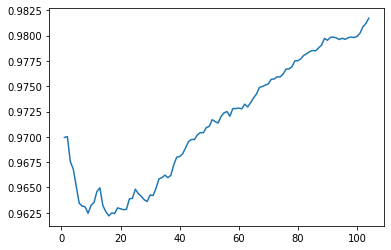

In [11]:
import matplotlib.pyplot as plt
plotting = np.array(plotting)
plt.plot(plotting[:, 0], plotting[:, 1])

From the above graph, we can observe a minima when no of features = 9